In [246]:
import wandb

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch

from dataset import get_learn_data, save_datasets
from topo_image import TopoImage, HeightFiltration
from models import UNet
from train import fit
from metrics import evaluate_model
from utils import set_random_seed

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%wandb login

UsageError: Line magic function `%wandb` not found.


In [79]:
RANDOM_SEED = 42
PIN_MEMORY = False 
NUM_WORKERS = 0

# Roads

## Data

### Generate Data

In [36]:
set_random_seed(RANDOM_SEED)

noise_transformations = A.Compose([
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=15, min_width=50, max_height=30, max_width=150, fill_value=0, p=1),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=50, min_width=15, max_height=150, max_width=30, fill_value=0, p=1),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=15, min_width=50, max_height=30, max_width=150, fill_value=0, p=0.7),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=50, min_width=15, max_height=150, max_width=15, fill_value=0, p=0.7)
])

train_loader, val_loader, test_loader = get_learn_data("data/Roads/tiff", "train_labels", "val_labels", "test_labels", 
                                                       noise_transformations=noise_transformations, patch_mode="split",
                                                       patch_size=(300, 300), img_size=(1500, 1500), batch_size=32, filter_empty=False)

save_datasets("data/Roads/patches_300/", [train_loader, val_loader, test_loader], ["train", "val", "test"])


100%|██████████| 39/39 [01:19<00:00,  2.03s/it]


In [140]:
set_random_seed(RANDOM_SEED)

train_loader, val_loader, test_loader = get_learn_data("data/Roads/patches_300", "train_gt", "val_gt", "test_gt", 
                                                       "train", "val", "test", noise_transformations=noise_transformations, 
                                                       patch_mode="resize", patch_size=(60, 60), img_size=(300, 300), batch_size=32, filter_empty=False)

save_datasets("data/Roads/patches_60/", [train_loader, val_loader, test_loader], ["train", "val", "test"], filter_empty=True)

100%|██████████| 39/39 [00:06<00:00,  5.77it/s]


### Load Data

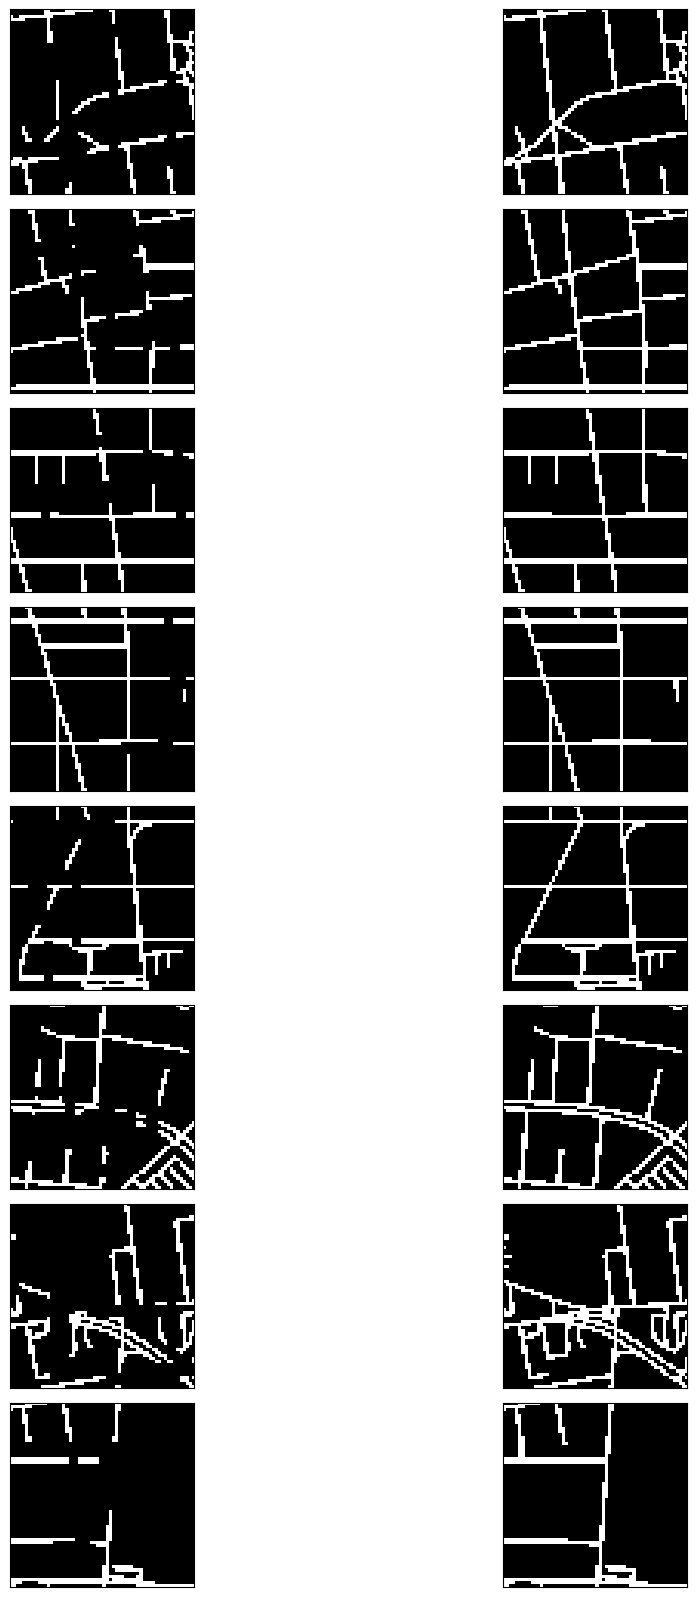

In [102]:
set_random_seed(RANDOM_SEED)

train_loader, val_loader, test_loader = get_learn_data("data/Roads/patches_60", "train_gt", "val_gt", "test_gt", 
                                                       "train", "val", "test", patch_mode="keep", 
                                                       img_size=(60, 60), batch_size=32, max_size=2500,
                                                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

fig = plt.figure(figsize=(10, 32))
for idx in np.arange(8):
    noised_image, gt_image, img_name, patch_num = test_loader.dataset[idx + 685]

    # noised input
    ax1 = fig.add_subplot(16, 2, 2 * idx + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_image), cmap='grey')

    # gt image
    ax3 = fig.add_subplot(16, 2, 2 * idx + 2, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_image), cmap='grey')

    fig.tight_layout()
plt.show()

In [82]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(2500, 325, 1031)

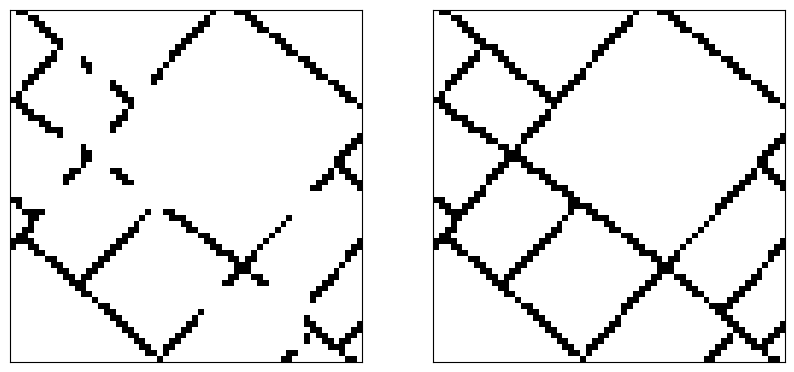

In [83]:
gt_img =  val_loader.dataset[35][1]
noised_img =  val_loader.dataset[35][0]

fig = plt.figure(figsize=(10, 32))

ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(1 - noised_img), cmap='grey')

ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(np.squeeze(1 - gt_img), cmap='grey')

plt.show()

In [84]:
TopoImage(gt_img).betti_numbers()

[2, 3, 0]

In [85]:
TopoImage(noised_img).betti_numbers()

[13, 0, 0]

## U-Net

### Only BCELoss

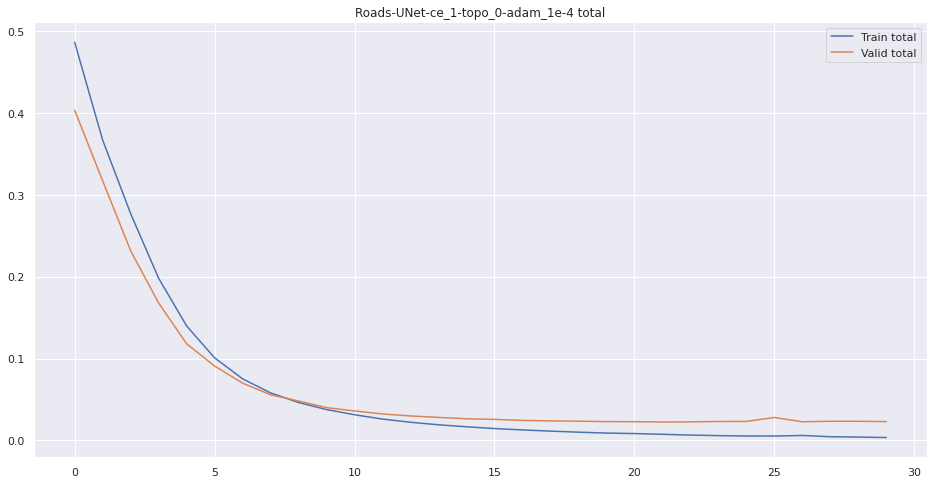

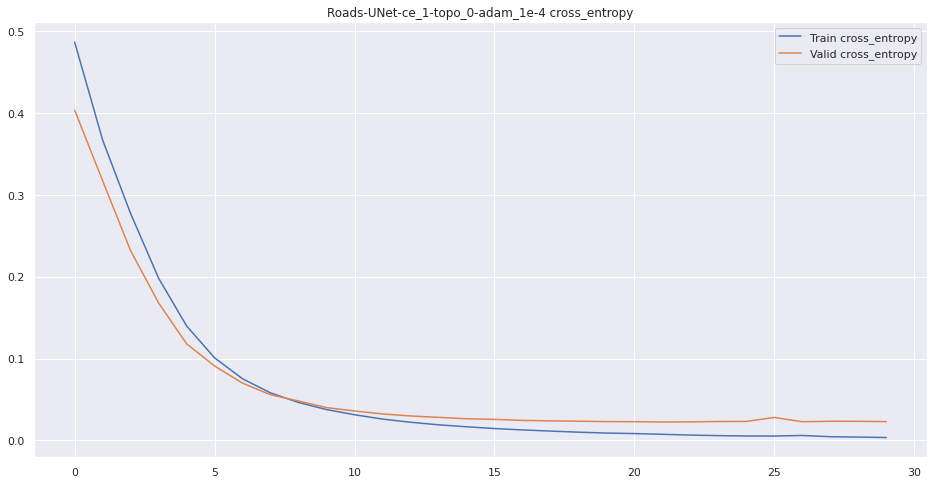

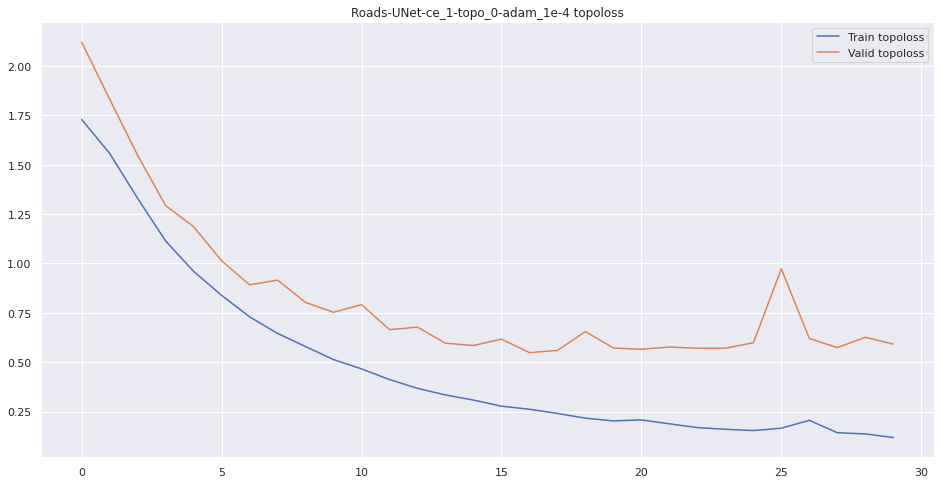

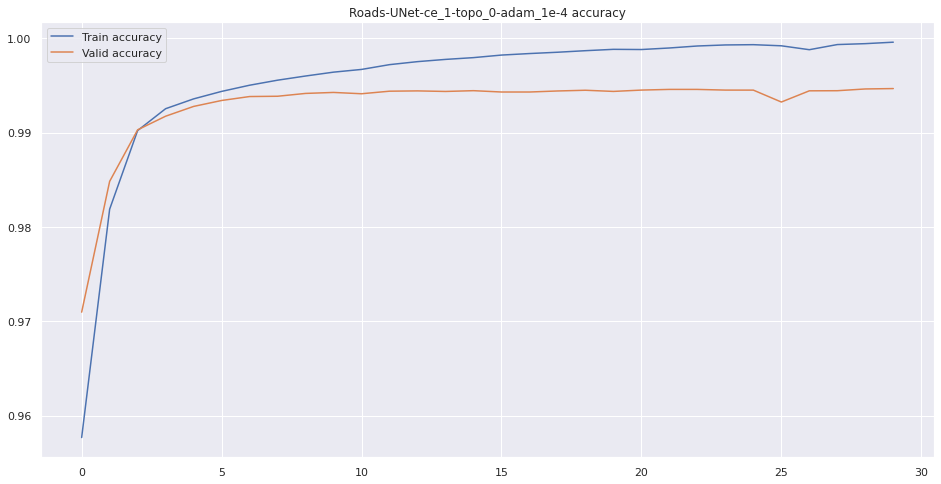

Epoch 29
 train loss: {'total': 0.003537612023204565, 'cross_entropy': 0.003537612023204565, 'topoloss': 0.11866935554742813}, train metrics: {'accuracy': 0.9995756776809692}
 val loss: {'total': 0.023003639510044686, 'cross_entropy': 0.023003639510044686, 'topoloss': 0.5916774100523728}, val metrics: {'accuracy': 0.994659865452693, 'betti_number_error': 1.3292307692307692, 'betti_number_error_0': 0.8, 'betti_number_error_1': 0.5292307692307693}



wandb:                                                                                
wandb: 
wandb: Run history:
wandb: lr ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: lr 0.0001
wandb: 
wandb: 🚀 View run Roads-UNet-ce_1-topo_0-adam_1e-4 at: https://wandb.ai/volodin-daniil/topological-autoencoder/runs/tpgmsmkt
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240512_013826-tpgmsmkt/logs


In [29]:
config = dict(
    net="UNet",
    dataset="Roads",
    lambda_ce=1,
    lambda_topo=0,
    batch_size=256,
    epochs=30,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = UNet()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

In [30]:
torch.save(net.state_dict(), "models/Roads/unet_bce.pt")

Using cache found in /Users/daniilvolodin/.cache/torch/hub/milesial_Pytorch-UNet_master
100%|██████████| 33/33 [00:34<00:00,  1.05s/it]


{'accuracy': 0.995986629526784, 'betti_number_error': 0.9311348205625606, 'betti_number_error_0': 0.623666343355965, 'betti_number_error_1': 0.30746847720659554}


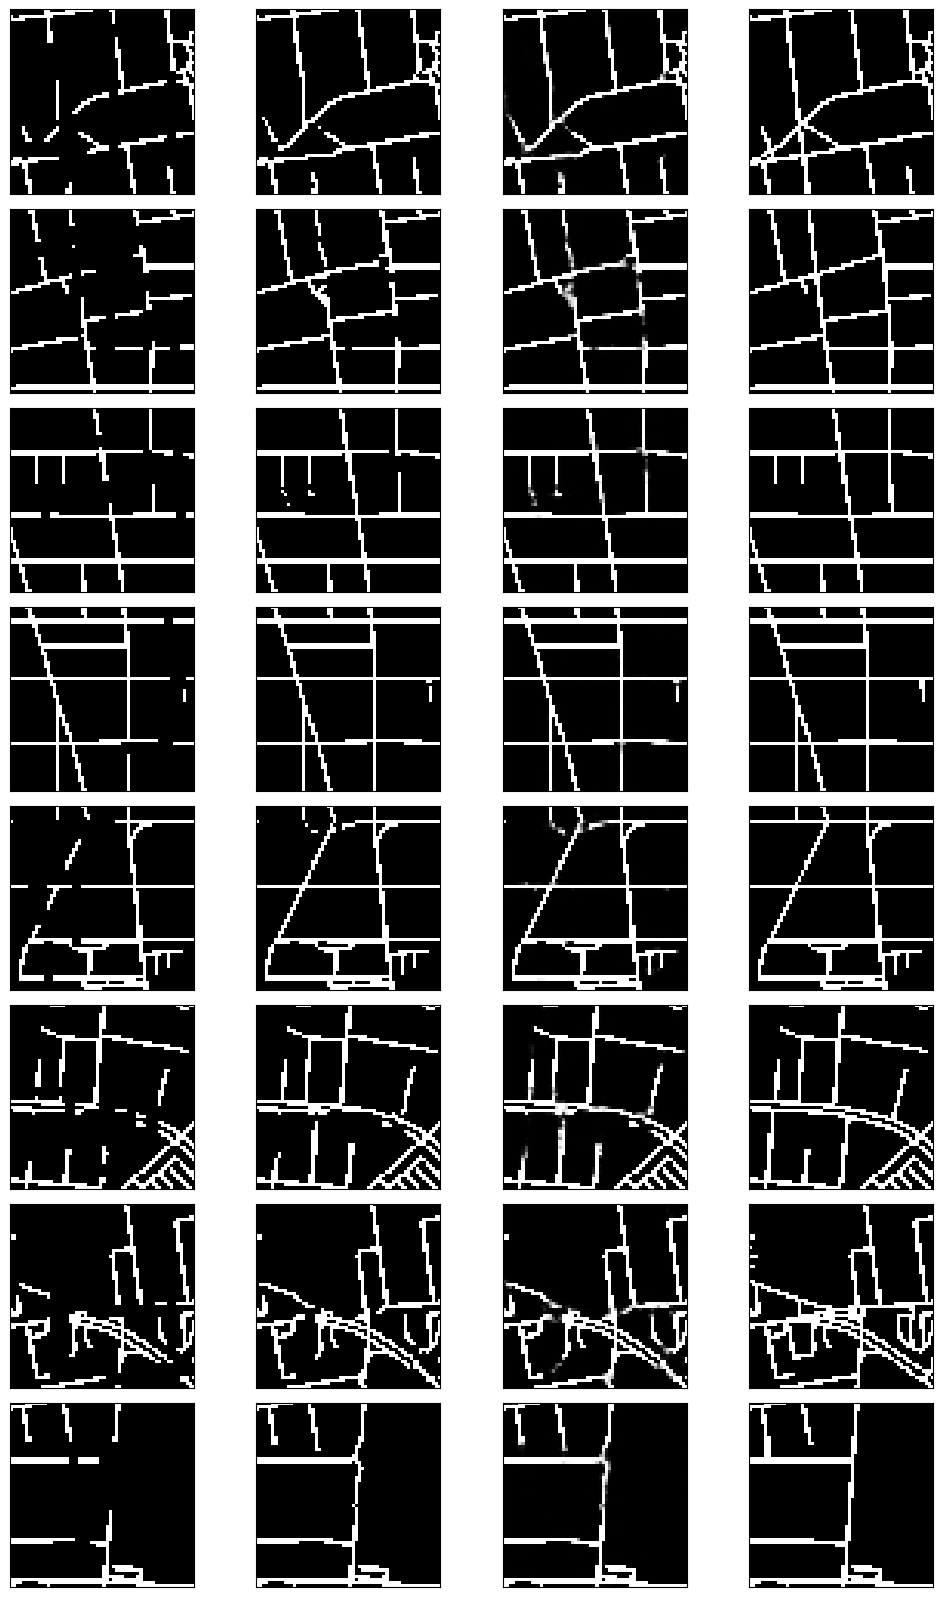

In [111]:
net = UNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/Roads/unet_bce.pt", map_location=device))

predictions_bce, predictions_bce_proba = evaluate_model(net, test_loader, device, start_ind=685)

### $\lambda = 0.1$

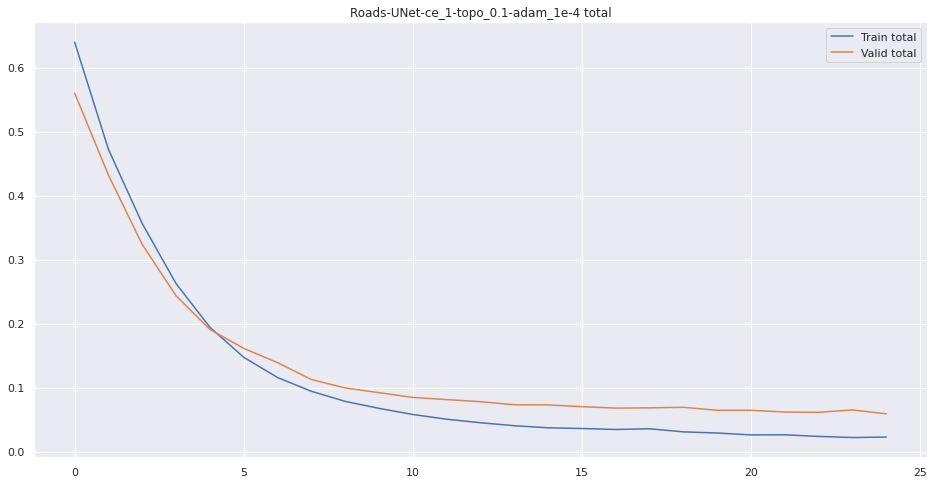

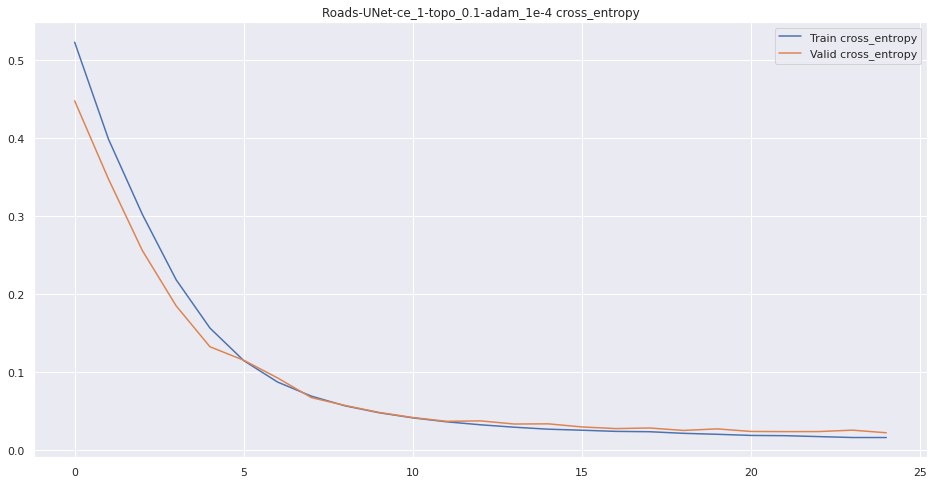

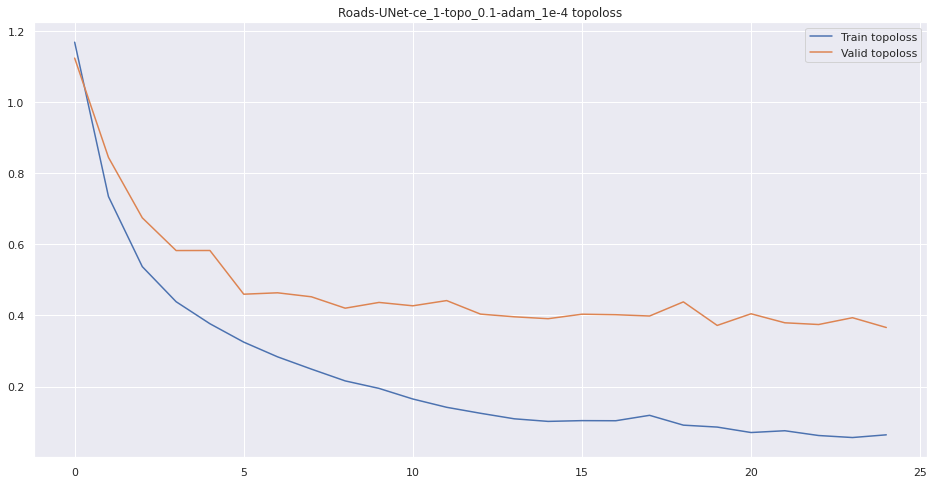

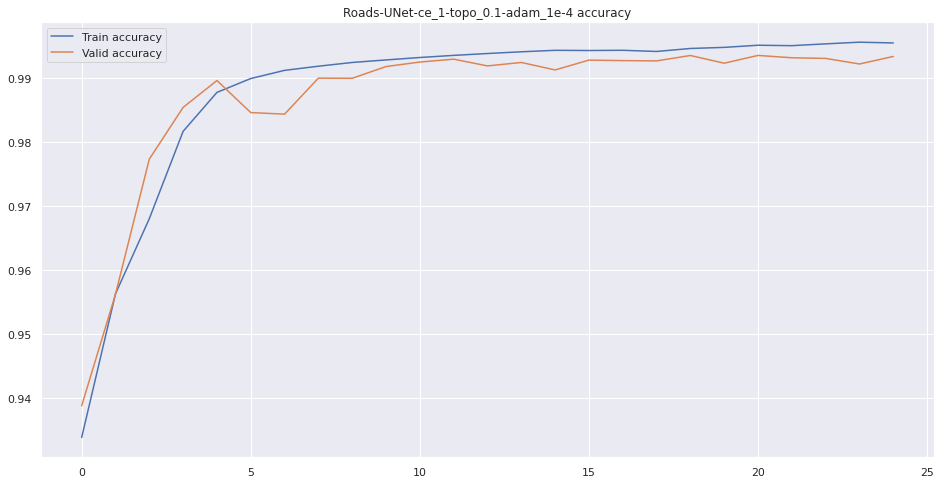

Epoch 24
 train loss: {'total': 0.02285287131071091, 'cross_entropy': 0.016413824629783632, 'topoloss': 0.06439046521186828}, train metrics: {'accuracy': 0.9955270269393921}
 val loss: {'total': 0.05913701497591459, 'cross_entropy': 0.02252297383088332, 'topoloss': 0.36614039201002857}, val metrics: {'accuracy': 0.993414541391226, 'betti_number_error': 0.76, 'betti_number_error_0': 0.38769230769230767, 'betti_number_error_1': 0.3723076923076923}



wandb:                                                                                
wandb: 
wandb: Run history:
wandb: lr ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: lr 0.0001
wandb: 
wandb: 🚀 View run Roads-UNet-ce_1-topo_0.1-adam_1e-4 at: https://wandb.ai/volodin-daniil/topological-autoencoder/runs/6ldrgdyu
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240512_154110-6ldrgdyu/logs


In [5]:
config = dict(
    net="UNet",
    dataset="Roads",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=256,
    epochs=25,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = UNet()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

In [ ]:
torch.save(net.state_dict(), "models/Roads/unet_bce_1_topo_1e-1.pt")

Using cache found in /Users/daniilvolodin/.cache/torch/hub/milesial_Pytorch-UNet_master
100%|██████████| 33/33 [00:35<00:00,  1.07s/it]


{'accuracy': 0.9951559958471822, 'betti_number_error': 0.5004849660523764, 'betti_number_error_0': 0.2618816682832202, 'betti_number_error_1': 0.23860329776915615}


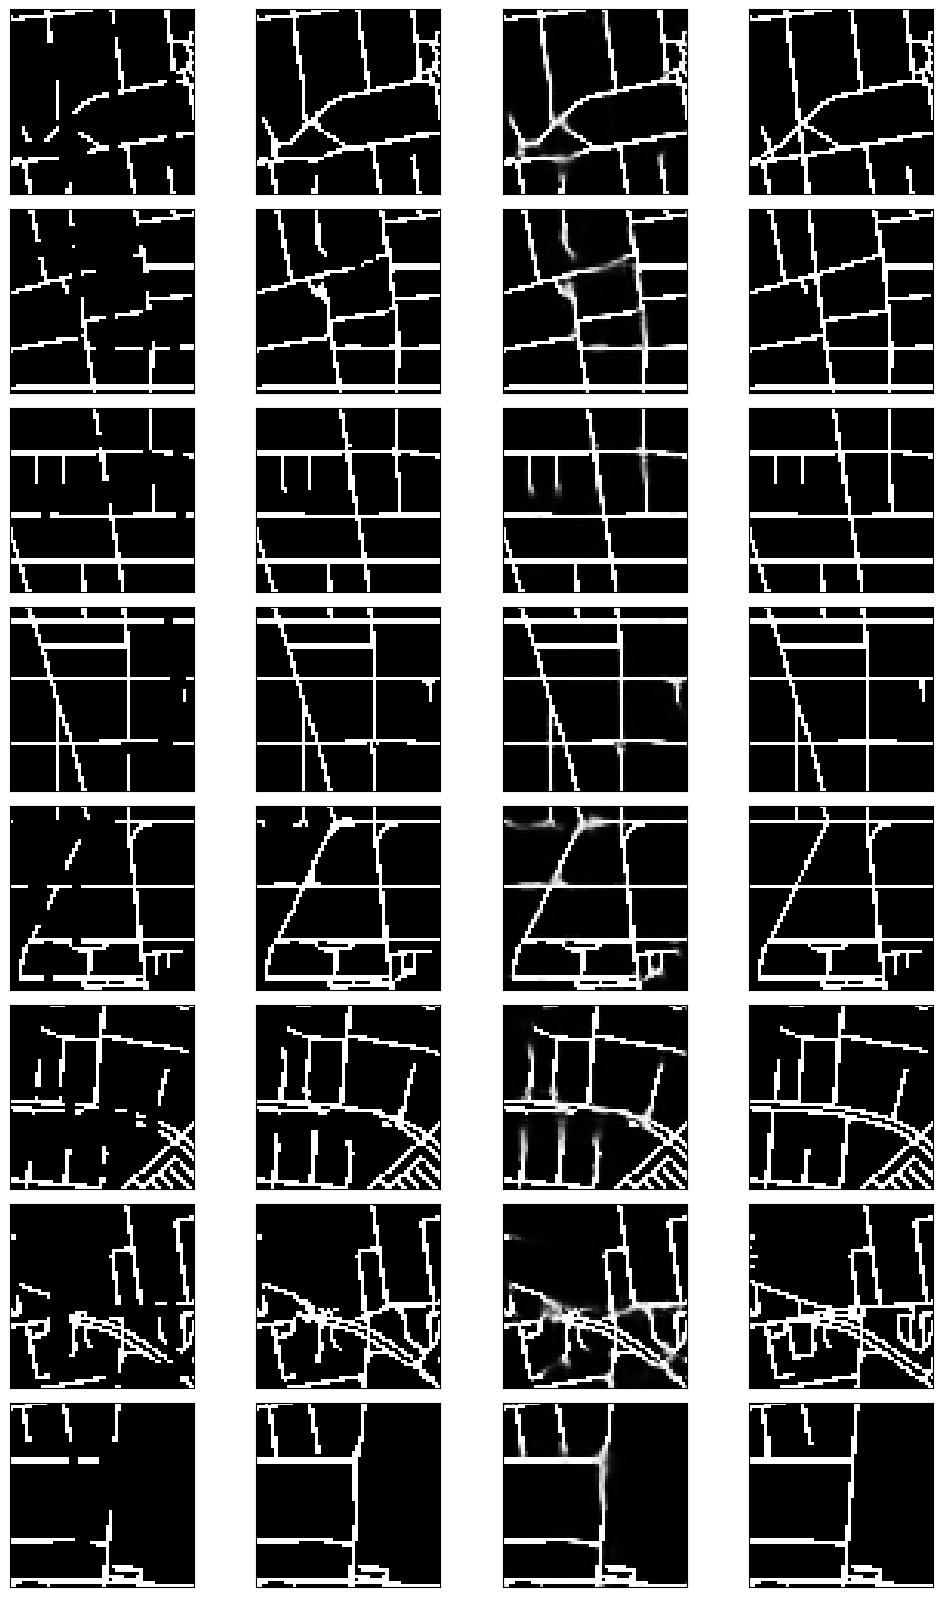

In [112]:
net = UNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/Roads/unet_bce_1_topo_1e-1.pt", map_location=device))

predictions_01, predictions_01_proba = evaluate_model(net, test_loader, device, start_ind=685)

### $\lambda = 0.15$

In [ ]:
config = dict(
    net="UNet",
    dataset="Roads",
    lambda_ce=1,
    lambda_topo=0.15,
    batch_size=256,
    epochs=25,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.15-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = UNet()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

In [ ]:
torch.save(net.state_dict(), "models/Roads/unet_bce_1_topo_15e-2.pt")

Using cache found in /Users/daniilvolodin/.cache/torch/hub/milesial_Pytorch-UNet_master
100%|██████████| 33/33 [00:34<00:00,  1.05s/it]


{'accuracy': 0.9946974403758747, 'betti_number_error': 0.5470417070805044, 'betti_number_error_0': 0.29776915615906885, 'betti_number_error_1': 0.2492725509214355}


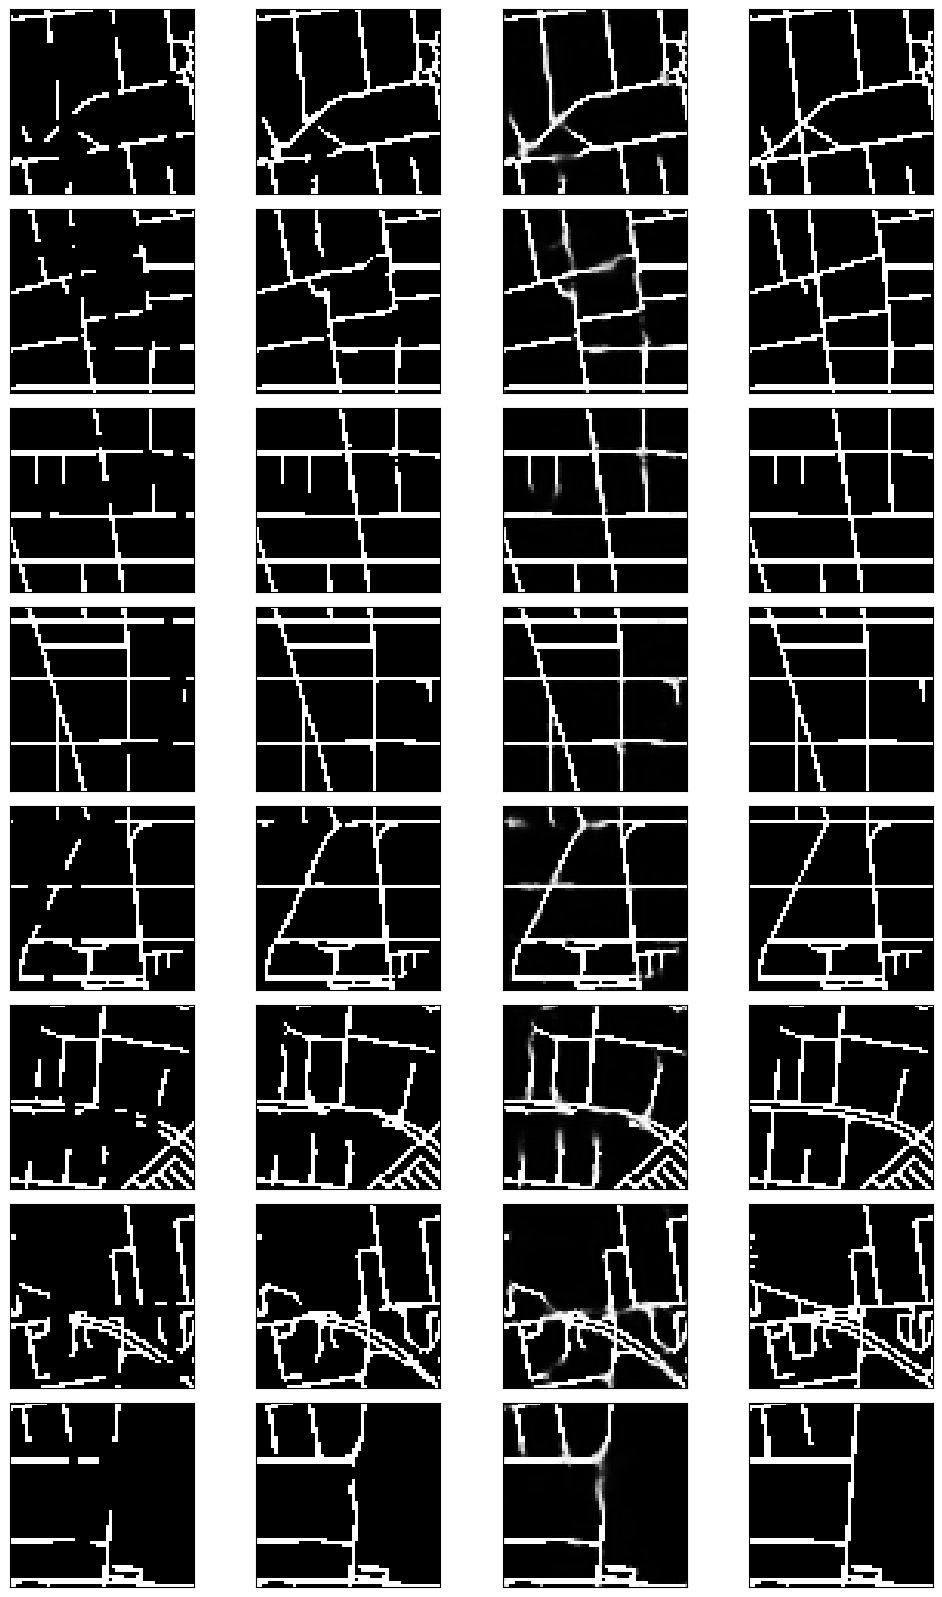

In [113]:
net = UNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/Roads/unet_bce_1_topo_15e-2.pt", map_location=device))

predictions_015, predictions_015_proba = evaluate_model(net, test_loader, device, start_ind=685)

### $\lambda = 0.05$

In [ ]:
config = dict(
    net="UNet",
    dataset="Roads",
    lambda_ce=1,
    lambda_topo=0.05,
    batch_size=256,
    epochs=25,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.05-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = UNet()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

In [ ]:
torch.save(net.state_dict(), "models/Roads/unet_bce_1_topo_5e-2.pt")

Using cache found in /Users/daniilvolodin/.cache/torch/hub/milesial_Pytorch-UNet_master
100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


{'accuracy': 0.995333278445106, 'betti_number_error': 0.6653734238603298, 'betti_number_error_0': 0.40446168768186225, 'betti_number_error_1': 0.2609117361784675}


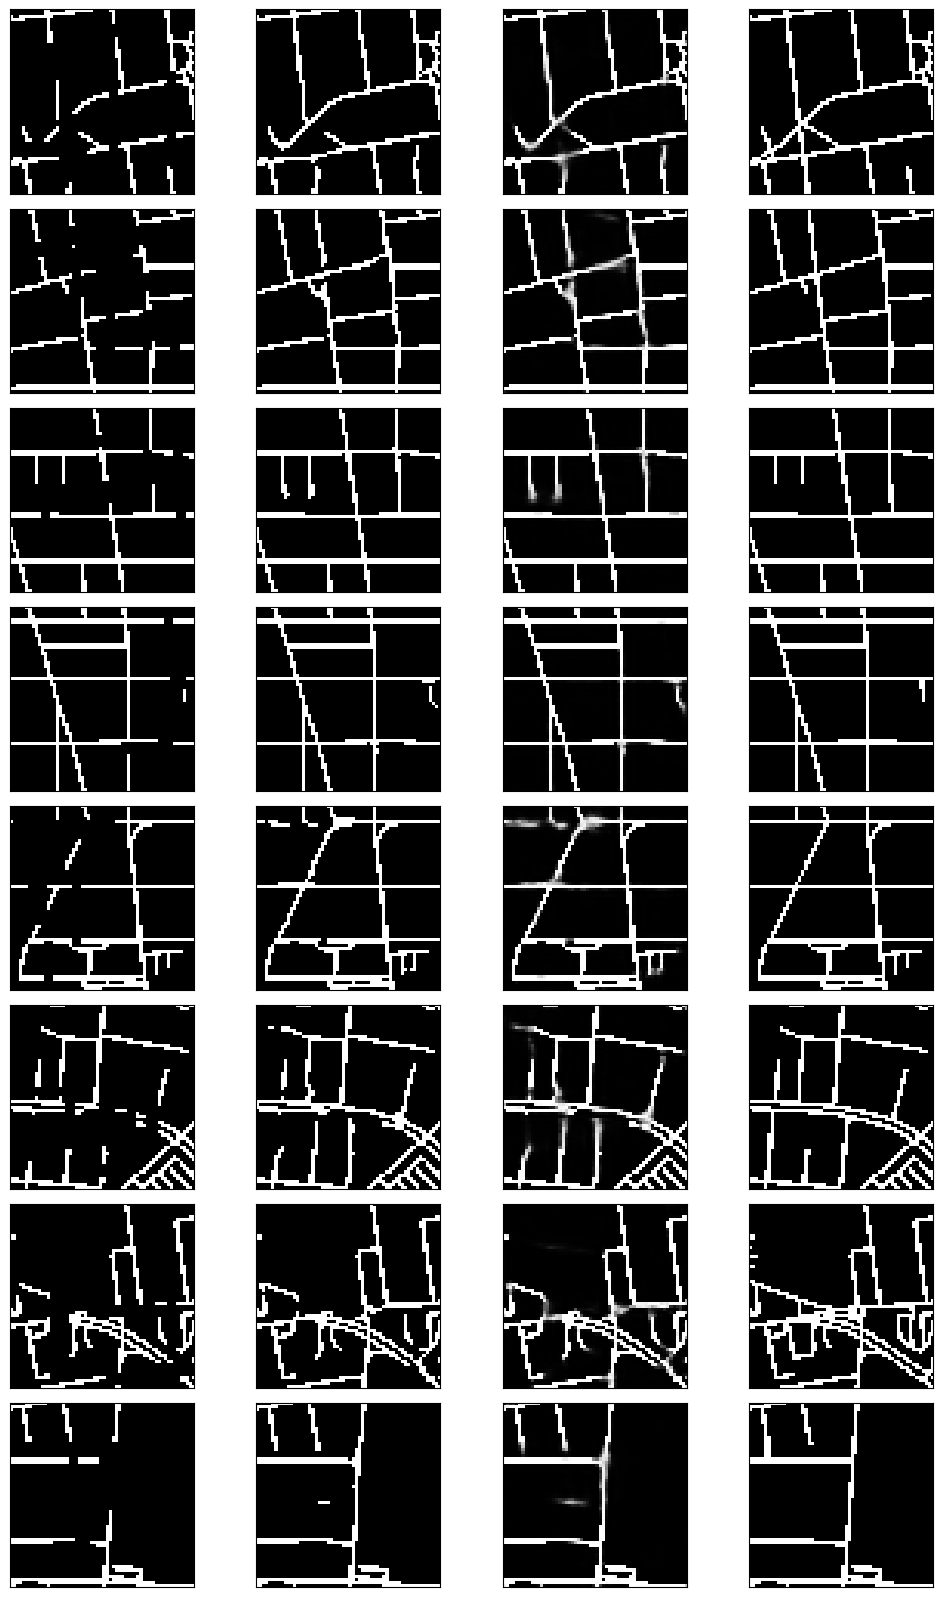

In [114]:
net = UNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/Roads/unet_bce_1_topo_5e-2.pt", map_location=device))

predictions_005, predictions_005_proba = evaluate_model(net, test_loader, device, start_ind=685)

### $\lambda = 0.1$ & Height Filtration (1, 1)

In [ ]:
config = dict(
    net="UNet",
    dataset="Roads",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=256,
    epochs=25,
    lr=1e-4,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['filtration']}_filtration_1_1-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = UNet()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((60, 60), np.array([1, 1]), device=device)

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [ ]:
torch.save(net.state_dict(), "models/Roads/unet_bce_1_topo_1e-1_height_filtration_1_1.pt")

Using cache found in /Users/daniilvolodin/.cache/torch/hub/milesial_Pytorch-UNet_master
100%|██████████| 33/33 [00:33<00:00,  1.02s/it]


{'accuracy': 0.9957280010996689, 'betti_number_error': 0.5460717749757517, 'betti_number_error_0': 0.33365664403491757, 'betti_number_error_1': 0.21241513094083414}


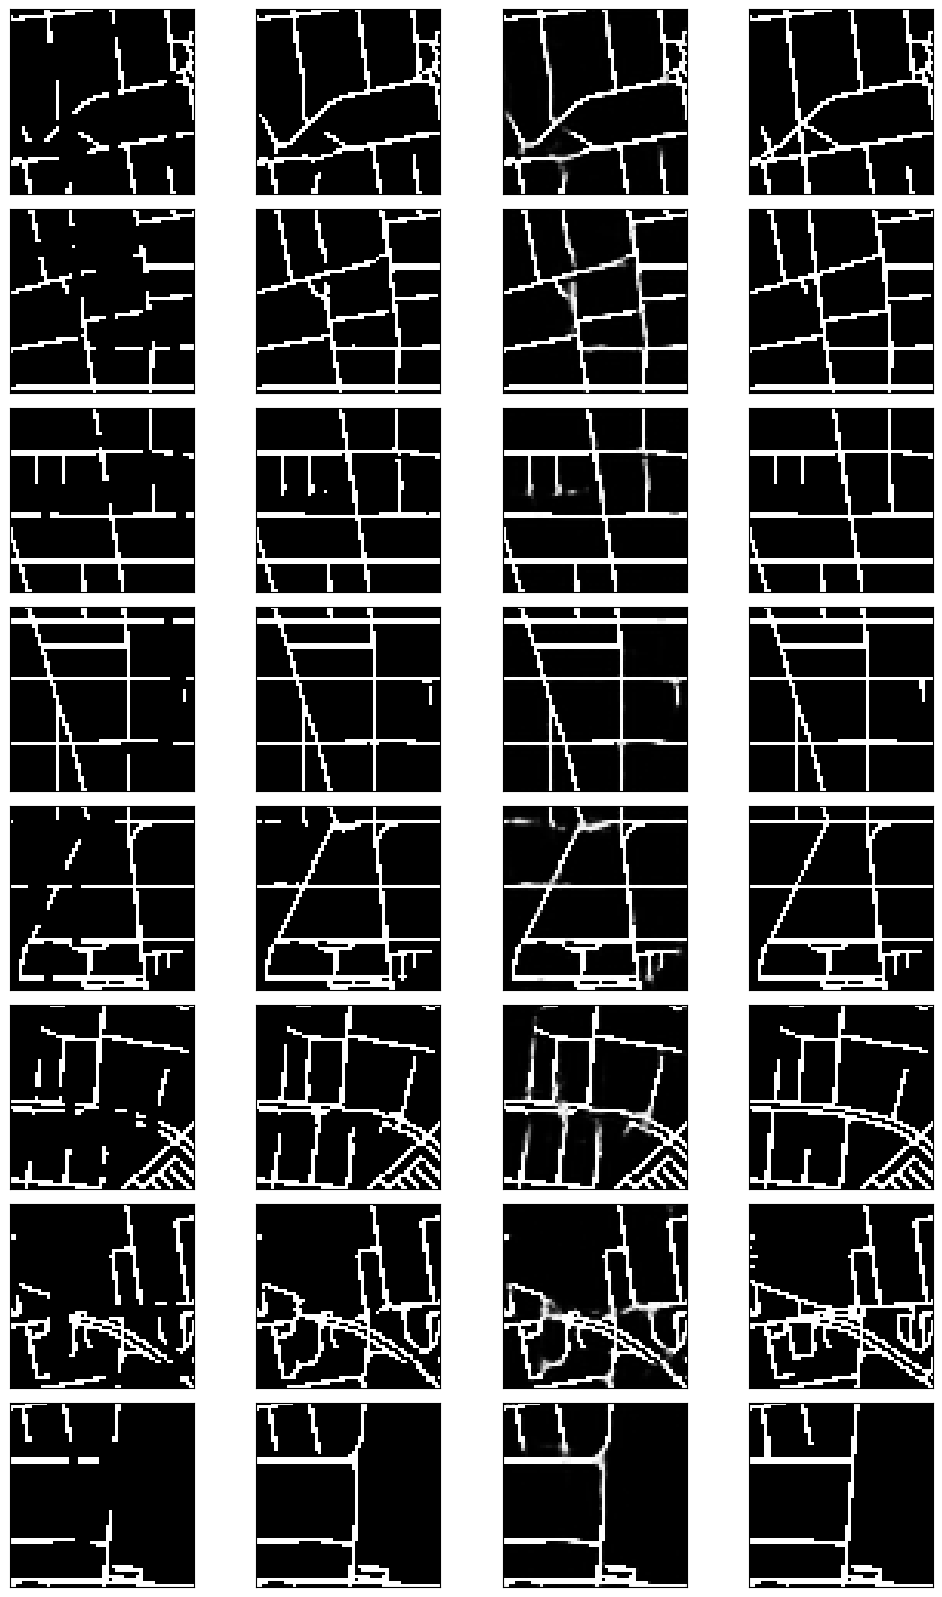

In [247]:
net = UNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/Roads/unet_bce_1_topo_1e-1_height_filtration_1_1.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=685)

## Filtrations

In [244]:
filtration = HeightFiltration((60, 60), np.array([1, 1]))
noised_batch, gt_batch, names_batch, patch_nums_batch = next(iter(train_loader))
filtered_batch = filtration(gt_batch).detach()

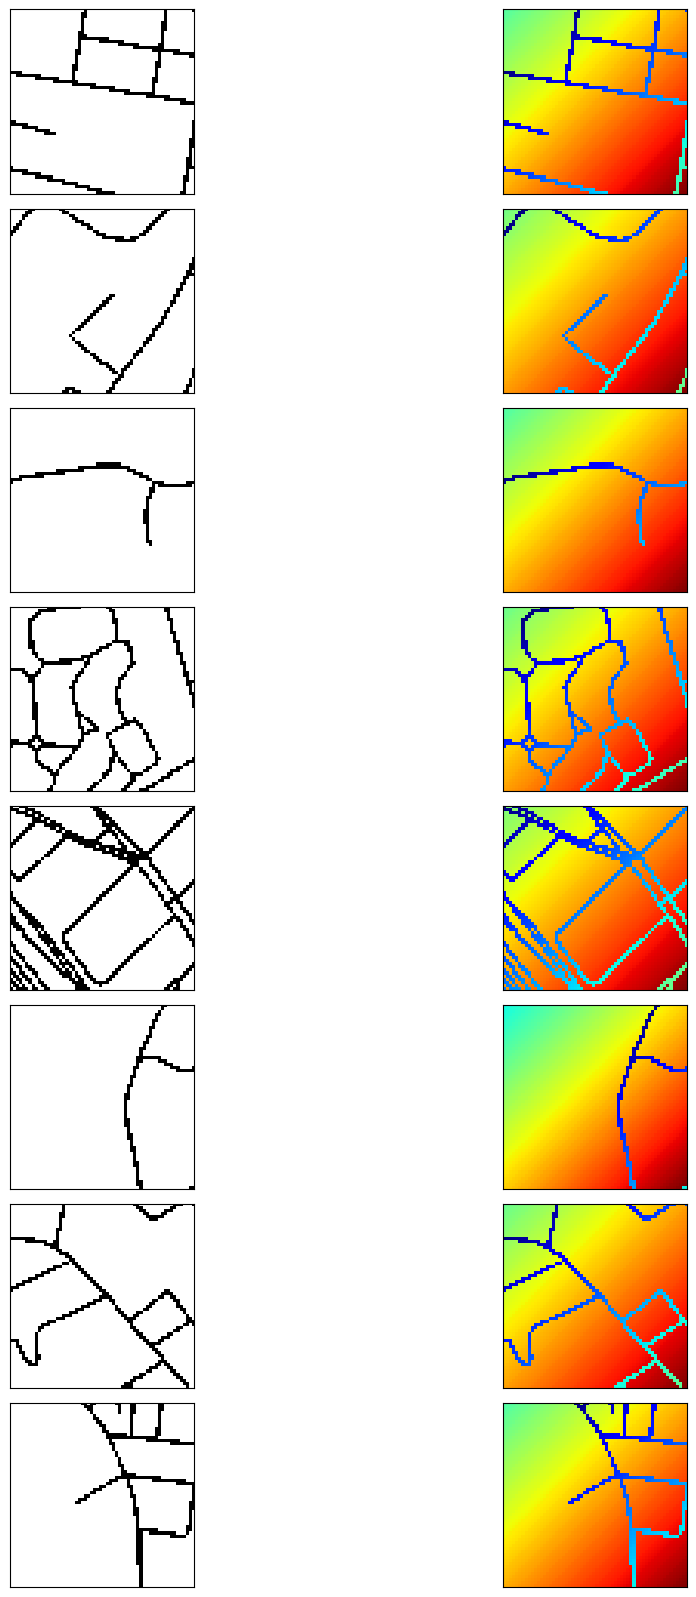

In [245]:
fig = plt.figure(figsize=(10, 32))
for idx in np.arange(8):
    # image
    ax1 = fig.add_subplot(16, 2, 2 * idx + 1, xticks=[], yticks=[])
    ax1.imshow(1 - np.squeeze(gt_batch[idx]), cmap='grey')

    # filtration
    ax3 = fig.add_subplot(16, 2, 2 * idx + 2, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(filtered_batch[idx]), cmap='jet')

    fig.tight_layout()
plt.show()